In [1]:
%load_ext autoreload
%autoreload 2

## Load packages

In [3]:
import scanpy as sc
import scvelo as scv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

In [4]:
from utils import RNAHalflifeDataloader, convert_gene_names, DataLoaderPseudoBulk, load_mouse_features

## Load mRNA Features for mouse

In [5]:
data_dir = '../../data/mouse/'

In [6]:
dataloader = RNAHalflifeDataloader(os.path.join(data_dir, 'mrnafeatures/gencode.vM25_GRCm38.primary_assembly/features_mouse_seq_codon_frequency_features.csv'))

## Read in tabula muris adata object

In [7]:
adata = scv.read(os.path.join(data_dir, "count_matrices/3_month_annotated.h5ad"))

In [8]:
# convert gene names to ensembl id
convert_gene_names(adata, gtf_file = data_dir+'genome/mouse/mm10/gencode.vM25.basic.annotation.gtf.gz')

In [9]:
# filter genes without id
adata = adata[:, ~adata.var.id.isnull()]

In [10]:
adata

View of AnnData object with n_obs × n_vars = 45146 × 21832
    obs: 'cell', 'batch', 'age', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'id'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Load major isoform table

In [11]:
isoform_table_path = os.path.join(data_dir, 'isoforms/mm10_major_isoforms_tms.csv')

## Create pseudobulk dataloader

In [12]:
dl = DataLoaderPseudoBulk(
      adata, 
      isoform_table_path, 
      dataloader, 
      celltype_key = 'cell_ontology_class',
      batchsize = None, 
      filter_cells = 150
)

150
Removed 58 celltypes as they had less cells than filter_cells 150
Computed 45 subcluster
Aggregating X and layers ['spliced', 'unspliced']


In [13]:
dl.compute_half_life(min_shared_cells=int(0.85*dl.adata.shape[0]))

Filtered out 14890 genes that are detected in less than 38 cells (shared).
Normalized count data: X, spliced, unspliced.


### Plot histogram

In [18]:
X = dl.adata.layers['spliced_raw'] + dl.adata.layers['unspliced_raw']

In [19]:
X_agg = X.sum(axis=0).A.squeeze()

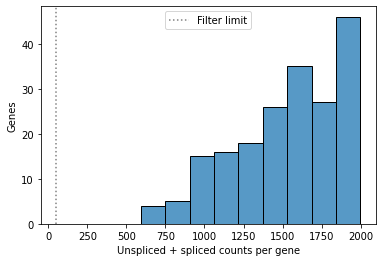

In [23]:
g = sns.histplot(X_agg[X_agg < 2000])
plt.axvline(50, color='gray', linestyle=':', label='Filter limit')
g.set( xlabel='Unspliced + spliced counts per gene', ylabel='Genes')
g.legend()

In [48]:
np.median(X[:, X_agg < 750].A, axis=0)

array([ 9.,  8., 10., 10.])

## Extract half life

In [24]:
hl_ln = pd.DataFrame(dl.adata.layers['half_life'].T, columns=dl.cell_types(), index = dl.adata.var.id)

In [25]:
id_to_isoform = dict(zip(dl.isoforms.index, dl.isoforms.hepatocyte))

In [26]:
hl_ln.index = hl_ln.index.map(id_to_isoform)

In [27]:
features = load_mouse_features(dataloader, dl, adata)

Filtering features table


In [28]:
features

,utr5,cds,utr3,AAA,AAC,AAG,AAT,ACA,ACC,ACG,...,gc_content_utr5,gc_content_utr3,gc_content_cds,log_length_utr5,log_length_utr3,log_length_cds,log_length,gene_id,gene_name,chromosome
transcript_id,,,,,,,,,,,,,,,,,,,,,
ENSMUST00000156816.6,GGAGCCGTAAAGCAACGCGGAGTCTACGCCGCTTCCTGGGCGCCCT...,ATGGCTGGCACGGCGCGCGGCTGCGGGACCAGCCTGGACCTGCTGC...,TGAACTGCCTTCTACTAAATCAGACTTGTGAGCCAGACGGGCTGCA...,0.033898,0.010169,0.030508,0.020339,0.006780,0.016949,0.006780,...,0.677419,0.453317,0.487006,1.792392,3.512684,2.946943,3.623559,ENSMUSG00000033845,Mrpl15,1
ENSMUST00000057438.6,TGCGGGGTGGGGTGGTGGCCGTTACGTTCGGGGCAACGGCTAAGGC...,ATGTCTCAGCCGCCGCCGCCTCCTCCGCTGCCGCCGCCGCCGCCTC...,TGATTTAATTTAGAGGCTAATAAAGGCAGAATGTTTATTGTGAATA...,0.039344,0.011475,0.024590,0.022951,0.016393,0.008197,0.004098,...,0.637168,0.334129,0.468033,2.354108,3.768120,3.563481,3.988960,ENSMUSG00000045210,Vcpip1,1
ENSMUST00000027050.9,GGCTTTGCGTCCCTCGCAGTTCACACGAACGGATTTCCGAGCCAGC...,ATGGCAGCTTCCGGGAGTGGTATGGCCCAGAAAACCTGGGAATTGG...,TAGTTACCACCAAGTACTTCTCAAAGCTGGTGTGTGGAAGGAAAAG...,0.062874,0.014970,0.014970,0.026946,0.017964,0.020958,0.000000,...,0.600000,0.372703,0.450100,2.498311,2.580925,3.000868,3.229938,ENSMUSG00000025917,Cops5,1
ENSMUST00000088615.10,CGGCCGCTCCGCGTCGCCGGCCGCTTCCTGGTGCCGCCGCTGCCCT...,ATGTATGAGGGCAAGAAGACGAAGAACATGTTCCTGACCCGGGCCC...,TGATGAGAGCCGATGTTTTTCTGTTGGTGTTTACATTGCTCTGCTC...,0.036295,0.018418,0.025460,0.022210,0.029794,0.008667,0.003250,...,0.795455,0.393987,0.417479,2.245513,3.101747,3.743353,3.843731,ENSMUSG00000067851,Arfgef1,1
ENSMUST00000081713.10,GACGCCGCGAGCCCTCCACTCTGGCGCGTCCCTTGGTCACCCGCAC...,ATGAGTGGGATGGGAGAAAACACCTCTGACCCGTCCAGGGCAGAGA...,TGACCCTGGAGAAACTGTCTGCATCTTTCTTCAACCCACTGGGCTT...,0.017229,0.033022,0.025126,0.022254,0.012922,0.017229,0.002872,...,0.525526,0.409401,0.539124,2.522444,3.563362,3.621072,3.912275,ENSMUSG00000005886,Ncoa2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUST00000033720.11,AGCTGCCTGGGCGGGCTGAGAGGCGCGGGTTGAAAAGTCTCGTTCC...,ATGGCGAGTAAAGAGATGTTTGAAGATACTGTGGAGGAGCGTGTCA...,TAAACCCAAAGTATGAGTTGTTTTTATTGAATGTATTGCTACATGA...,0.032941,0.011765,0.023529,0.040000,0.014118,0.014118,0.002353,...,0.658621,0.354934,0.447059,2.462398,2.831870,3.105510,3.351023,ENSMUSG00000031353,Rbbp7,X
ENSMUST00000112303.7,GAGGGTGATGGGAGCTGCCTGTGCTATAGGAAACACTTTTTAGGCG...,ATGAAGTATATCCTGGTTACTGGTGGGGTCATCTCAGGCATTGGTA...,TGAAGCTCTTTCTTGCCTCAGGAATAGCAGAAGCTACCTAAGAGGC...,0.032423,0.032423,0.034130,0.020478,0.010239,0.010239,0.003413,...,0.598540,0.398568,0.453356,2.437751,3.099335,3.245019,3.517064,ENSMUSG00000031360,Ctps2,X
ENSMUST00000069041.14,AGCTTGGCGCGCGGTCTCCGGTCCGCCTCTCCGCTCGCCGCAGCCC...,ATGCAGTTTATGTTGCTTTTTAGTCGCCAGGGAAAGCTTCGACTGC...,TAACTGTCCTCCCTTGCTGATGACTTCTTGTGGCATTTCACACTGT...,0.043750,0.000000,0.056250,0.018750,0.018750,0.018750,0.000000,...,0.766537,0.366017,0.397917,2.409933,3.172895,2.681241,3.347525,ENSMUSG00000031367,Ap1s2,X


In [29]:
pbulk_table = features.join(hl_ln)
pbulk_table = pbulk_table.reset_index()

In [30]:
pbulk_table.to_csv(data_dir+'mouse_pseudo_bulk_hl.csv', sep = '\t')

## Extract expression

In [31]:
adata_pbulk = dl.adata[:, pbulk_table.gene_name]

(array([4.70600e+03, 2.39080e+04, 6.33480e+04, 1.03597e+05, 7.44770e+04,
        2.68980e+04, 7.52000e+03, 3.19800e+03, 1.06500e+03, 3.30000e+01]),
 array([ 0.05569308,  1.2363712 ,  2.4170492 ,  3.5977273 ,  4.778405  ,
         5.959083  ,  7.1397614 ,  8.320439  ,  9.501118  , 10.681795  ,
        11.8624735 ], dtype=float32),
 <BarContainer object of 10 artists>)

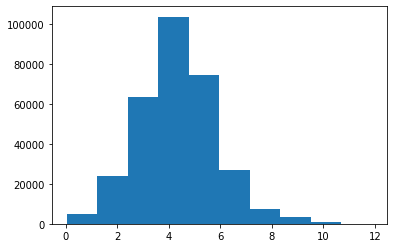

In [33]:
plt.hist(adata_pbulk.X.data)

In [34]:
expression = pd.DataFrame(adata_pbulk.X.A.T, columns=hl_ln.columns.values, index = adata_pbulk.var.index)

In [35]:
expression.loc[:, 'gene_id'] = pbulk_table.gene_id.values

In [36]:
expression

,hepatocyte,endothelial cell,macrophage,mesenchymal stem cell,B cell,skeletal muscle satellite cell,T cell,basal epithelial cell of tracheobronchial tree,mesenchymal progenitor cell,granulocyte,...,precursor B cell,promonocyte,DN4 thymocyte,immature T cell,double negative T cell,thymocyte,bladder urothelial cell,bladder cell,fibroblast of cardiac tissue,gene_id
Mrpl15,4.612178,3.576429,4.367166,3.259667,4.599527,3.435951,4.416400,3.436873,3.335648,3.000792,...,4.591163,4.543295,5.196423,5.039173,5.110971,5.269109,3.286285,3.530207,4.392560,ENSMUSG00000033845
Vcpip1,4.722358,4.491869,4.575613,3.718854,4.790606,4.180772,4.532514,4.666393,4.358259,4.251038,...,5.210598,5.017280,4.463503,4.882059,4.271681,4.072669,4.810496,4.400126,5.044635,ENSMUSG00000045210
Cops5,5.397862,5.053063,5.203177,4.988338,5.049861,4.797803,4.868524,5.052819,4.993325,4.198171,...,5.057356,5.533390,5.433208,5.691927,5.918546,6.125820,4.718164,5.134683,4.951741,ENSMUSG00000025917
Arfgef1,5.387187,4.815952,4.754330,4.134590,5.147734,3.830627,4.664373,5.384839,4.615605,5.137748,...,4.940369,4.700480,3.781812,4.376275,4.672483,4.050332,5.880626,4.716990,5.044635,ENSMUSG00000067851
Ncoa2,4.679731,3.840916,4.034833,3.755013,3.880445,3.112275,4.208616,4.214006,3.942466,3.542599,...,4.190756,4.219508,3.841095,3.904408,3.873171,3.653538,3.733715,3.894243,4.357911,ENSMUSG00000005886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rbbp7,5.211660,5.910695,5.851394,6.036313,5.884134,6.411261,5.656690,6.345349,6.017559,3.943387,...,5.820703,6.240276,6.597015,5.599473,6.447133,7.146810,6.247567,6.587465,6.218819,ENSMUSG00000031353
Ctps2,3.041692,4.325691,4.399097,4.422825,4.906997,3.732825,4.806980,3.800008,4.282055,3.628443,...,4.342742,5.398163,5.385221,5.331283,5.707869,4.944639,3.672462,4.548355,4.549805,ENSMUSG00000031360
Ap1s2,0.461524,5.056696,5.257907,5.375852,4.441669,3.961443,4.141457,2.099757,4.636022,5.430014,...,5.084584,6.580639,4.399732,5.236456,5.074827,4.468731,0.426979,3.844865,5.222918,ENSMUSG00000031367
Gemin8,2.008400,2.058628,2.675390,2.975068,2.208781,2.260600,2.848533,2.939716,2.901197,1.410385,...,3.634279,2.484907,3.417420,3.826044,3.592396,4.177431,2.024059,2.992327,3.867171,ENSMUSG00000040621


In [37]:
expression.to_csv(data_dir+'mouse_gene_expression.csv', sep = '\t')